# Regression test case selection using quantum algorithms
Regression testing is an important part of the software development process in software engineering. It is a practice aimed at identifying any regression, which are the emergence of new defects or issues in a software application following changes, enhancements, or updates made to the source code. In other words, regression testing focuses on how changes made to the software can affect the correct behavior of existing features. Regression testing is particularly important in agile software development environments, where changes are made frequently and rapidly. This practice helps ensure that the software remains stable and reliable as it evolves over time. To conduct regression testing, it is necessary to identify a set of test cases that covers the existing functionalities of the software; this problem is known as the "Test Case Selection" problem.
The problem of test case selection is a critical component of the regression testing process in the field of software engineering. This problem arises when choosing the test cases to be executed during a regression testing session, particularly when making changes to existing software.
The project presented in this notebook is aimed at solving the test case selection problem for regression testing using a quantum algorithm (which will be explained later). This problem will be treated as a binary variable optimization problem to obtain a subset of the original test suite of a program under observation, with the objectives of minimizing the test execution cost and maximizing the probability of detecting errors and test code coverage.

In [1]:
#this cell contains all the imports needed by the pipeline
#to run it on the browser: jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
import json
import math
import time

from dwave.system import LeapHybridSampler
import dimod
from pathlib import Path
import matplotlib.pyplot as plt
import random
import numpy as np
import statistics
import csv
import pandas as pd

In [158]:
#this cell contains all variable definitions that will be useful throughout the entire project
sir_programs = ["sed"]
sir_programs_tests_number = {"flex":567,"grep":806,"gzip":214,"sed":360}
sir_programs_end_lines = {"flex":14192,"grep":13281,"gzip":6701,"sed":7118}
alpha = 0.5
tot_run = 10

## The pipeline dataset
To experiment the performance of the proposed solution by this work and to compare its results to those of state-of-the-art solutions, 4 public programs have been downloaded from the SIR website. SIR is a repository of software-related artifacts meant to support rigorous controlled experimentation with program analysis and software testing techniques, and education in controlled experimentation. 

### Chosen SIR Programs
The programs that will be used for experimentation have all been written in C and are:
- flex (a program that generates a lexical analysis program, based on regular expressions and C statement contained in one or more input files);
- grep (a useful program to search form matching patterns in a file);
- gzip (a program that substitute a file, generally text files or web pages, with their compressed version)
- sed (a powerful program for stream text editing).

### Needed information
The information needed by the quantum algorithm to work on every one of the 4 programs are:
- a fault matrix: it indicates whether a precise test case already found, during previous execution, a bug in the source code or not;
- execution cost: it indicates the execution cost of any test case of the suite;
- statement coverage: it indicates statement coverage information for every test case. 

All this information have been gathered through previous experimentation on the four programs mentioned above and written in files organized in the SIR_Programs folder. So, the first goal of the project will be gathering data from these files for computational purposes.

In [132]:
#let's make a function to read the fault matrices
#IMPORTANT: all the fault-matrix files must be renamed as "fault-matrix".txt and must be written using the same standard used by the files of this project (i-th line->e0e1e2e3..., where ej is 0 if the i-th test found a bug when launched on the j-th version)
def get_fault_list(program_name:str):
    """This function opens the fault-matrix file of a sir programs and makes a list of binary values for each test case of that program to indicate whether a test case found or not a bug in at least one of the available versions of the program"""
    #open the fault-matrix file of the desired SIR program
    program_file = open("SIR_Programs/"+program_name+"/fault-matrix.txt")
    lines = program_file.readlines()
    
    #we need a list which elements represent test cases, the i-th element is 1 if the i-th test case
    #discovered a fault in the past, 0 otherwise
    faults_test_by_test = list()
    
    i = 0
    for line in lines:
        if "1" in line:
            faults_test_by_test.append(1)
        else:
            faults_test_by_test.append(0)
        i += 1
    
    program_file.close()
    
    return faults_test_by_test

In [133]:
#the next function is able to research into the json coverage information file of each test case
#of each sir program to gather information about the single test cases costs and coverage
def cost_and_coverage_information_gathering(program_name:str):
    """The aim of this function is to obtain a dictionary that for each test case of a program indicates its cost, and a dictionary that, for each code line of the program to test, makes a list of all the test cases that run that line"""
    test_case_execution_cost = 0
    
    execution_cost_test_by_test = dict()
    executed_lines_test_by_test = dict()
    lines_of_tests_list = dict()
    total_file_lines = 0
    read_files = []
    
    for test_case in range(sir_programs_tests_number[program_name]):
        #to open the correct file, we must remember that the folders and the json files are
        #numbered from 1 and not from 0
        if program_name == "gzip":
            json_name = "allfile"
        else:
            json_name = program_name
        test_case_json = open("SIR_Programs/"+program_name+"/json_"+program_name+"/t"+str(test_case+1)+"/"+json_name+str(test_case+1)+".gcov.json")
        
        #read the JSON object as a dictionary
        json_data = json.load(test_case_json)
        
        # to have coverage % we will need the total number of lines to cover
        for file in json_data["files"]:
            if file["file"] not in read_files:
                total_file_lines += len(file["lines"])
                read_files.append(file["file"])
        
        #for programs tested above more than one file, the initial row of a file will start from
        #the final row of the preceding file
        i = 0
        for file in json_data["files"]:
            line_count_start = i
            for line in file["lines"]:
                #if a line is executed, we want to remember FOR THAT LINE which are the tests
                #that executed it, and we want to increment the execution cost
                if line["unexecuted_block"] == False:
                    #the test suite exec cost = sum of the exec freq. of each executed basic block
                    #by each test case
                    #test_suite_execution_cost += line["count"]
                    test_case_execution_cost += line["count"]
                    
                    if (line_count_start + line["line_number"]) not in executed_lines_test_by_test:
                        executed_lines_test_by_test[line_count_start + line["line_number"]] = [test_case]
                    else:
                        executed_lines_test_by_test[line_count_start + line["line_number"]].append(test_case)
                    executed_lines_test_by_test[line_count_start + line["line_number"]].sort()
                    
                    if test_case not in lines_of_tests_list:
                        lines_of_tests_list[test_case] = [line_count_start + line["line_number"]]
                    else:
                        lines_of_tests_list[test_case].append(line_count_start + line["line_number"])
                    lines_of_tests_list[test_case].sort()
                i = line["line_number"]
        
        #saving the total amount of execution cost for this test case and resetting for the next
        execution_cost_test_by_test[test_case] = test_case_execution_cost
        test_case_execution_cost = 0
        
        test_case_json.close()
                        
    return execution_cost_test_by_test, executed_lines_test_by_test, lines_of_tests_list, total_file_lines
                    

In [159]:
#we can now gain all the historical information about past fault detection 
faults_dictionary = {"flex": None, "grep": None, "gzip": None, "sed": None}

for sir_program in sir_programs:
    faults_dictionary[sir_program] = (get_fault_list(sir_program))
    
print(faults_dictionary)

{'flex': None, 'grep': None, 'gzip': None, 'sed': [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [160]:
#we can now gain costs and coverage information

test_cases_costs = {"flex":None,"grep":None,"gzip":None,"sed":None}
coverage = {"flex":None,"grep":None,"gzip":None,"sed":None}
lines_of_tests_list = {"flex":None,"grep":None,"gzip":None,"sed":None}
total_file_lines = {"flex":None,"grep":None,"gzip":None,"sed":None}

for sir_program in sir_programs:
    costs_and_coverage = cost_and_coverage_information_gathering(sir_program)
    test_cases_costs[sir_program] = costs_and_coverage[0]
    coverage[sir_program] = costs_and_coverage[1]
    lines_of_tests_list[sir_program] = costs_and_coverage[2]
    total_file_lines[sir_program] = costs_and_coverage[3]

print(test_cases_costs)
print(lines_of_tests_list)
print(total_file_lines)

{'flex': None, 'grep': None, 'gzip': None, 'sed': {0: 104, 1: 104, 2: 68, 3: 52, 4: 99, 5: 58504, 6: 59629, 7: 56861, 8: 33672, 9: 34663, 10: 99, 11: 99, 12: 6931, 13: 28, 14: 28, 15: 35787, 16: 4931, 17: 2749, 18: 51593, 19: 26885, 20: 6616, 21: 49947, 22: 49992, 23: 50067, 24: 50125, 25: 51114, 26: 114657, 27: 262595, 28: 43395, 29: 131263, 30: 143727, 31: 1811, 32: 3691, 33: 35039, 34: 3763, 35: 81274, 36: 31753, 37: 29695, 38: 29695, 39: 31596, 40: 32284, 41: 32104, 42: 29196, 43: 32449, 44: 8882, 45: 8205, 46: 8574, 47: 8574, 48: 22932, 49: 108834, 50: 7881, 51: 98752, 52: 51613, 53: 51204, 54: 49750, 55: 51330, 56: 59365, 57: 59286, 58: 59276, 59: 33759, 60: 62276, 61: 62318, 62: 62313, 63: 62350, 64: 30379, 65: 30646, 66: 30631, 67: 30646, 68: 4441, 69: 4824, 70: 4819, 71: 4824, 72: 184061, 73: 184398, 74: 184313, 75: 184388, 76: 52273, 77: 52666, 78: 29696, 79: 32245, 80: 29472, 81: 31871, 82: 29472, 83: 31808, 84: 33956, 85: 34320, 86: 32460, 87: 31795, 88: 31145, 89: 31815, 9

## Additional Greedy
One of the classical strategies generally used to solve the test case selection problem is the "Additional Greedy" approach. This strategy is applied using the standard weighted sum approach to conflate all the objectives into one single function to optimize.

In [31]:
def lines_to_cover(sir_program):
    lines_to_cover = set()
    
    for covered_lines in lines_of_tests_list[sir_program].values():
        for covered_line in covered_lines:
            lines_to_cover.add(covered_line)
            
    return lines_to_cover

def additional_greedy(sir_program):
    c = set()
    p = lines_to_cover(sir_program)
    s = []
    pareto_front = []
    test_cases_already_selected = []
    while len(c) < len(p):
        weighted_sum = {}
        for test_case in range(0,sir_programs_tests_number[sir_program]):
            if test_case not in test_cases_already_selected and test_case in lines_of_tests_list[sir_program].keys():
                max_cost = max(test_cases_costs[sir_program].values())
                added_coverage = [line for line in lines_of_tests_list[sir_program][test_case] if line not in c]
                weighted_sum[test_case]=((0.5 * (len(added_coverage)/len(lines_of_tests_list[sir_program][test_case]))) + (0.5 * faults_dictionary[sir_program][test_case]))/(test_cases_costs[sir_program][test_case]/max_cost)
        best_test_case = min(weighted_sum,key=weighted_sum.get)
        test_cases_already_selected.append(best_test_case)
        for covered_line in lines_of_tests_list[sir_program][best_test_case]:
            c.add(covered_line)
        s.append(best_test_case)
        pareto_front.append(s.copy())
    
    return pareto_front

for sir_program in sir_programs:
    with open(f"results/add-greedy/{sir_program}_data.json", "w") as file:
        json_data = {}
        start = time.time()
        json_data["pareto_front"] = additional_greedy(sir_program)
        end = time.time()
        json_data["resolution_time(ms)"] = (end-start)*1000
        json.dump(json_data,file)

## Quantum Annealing
Quantum annealing is a quantum computing technique used by D-Wave Systems, and it's designed to solve combinatorial optimization problems.

Quantum annealing leverages the principles of quantum mechanics to search for optimal or approximate solutions to optimization problems. It relies on a gradual transition from an initial state to a final state through a process known as "annealing." During this transition, the system aims to minimize an objective function, which must be formulated in a way that can be tackled by the quantum annealer. This involves translating the problem into a mathematical form known as "Quadratic Unconstrained Binary Optimization" (QUBO), which is suitable for representation on a quantum computer.

D-Wave's quantum annealer uses quantum qubits to simultaneously explore different combinations of variable values, seeking the optimal solution. During the annealing process, transition probabilities between quantum states are adjusted to minimize the objective function. At the end of the annealing process, a solution is obtained, representing a potential assignment of values to the problem's variables while aiming to minimize the objective function.

## QUBO Problems
A Quadratic Unconstrained Binary Optimization (QUBO) problem is a type of mathematical problem where we seek to find the best combination of binary values (0 or 1) for a set of variables to minimize or maximize an objective function. In other words, we are looking for the optimal solution among all possible variable combinations that satisfies certain constraints and makes the objective function as small as possible.

Weights for constraints (or penalty coefficients) are used in QUBO problems to assign a numerical value to the constraints and influence the optimization process. These weights are important because they allow for managing the priority and relative importance of constraints within the optimization problem.

In [35]:
def create_adjvector_bqm(sir_program, alpha, P):
    """This function is the one that has to encode the QUBO problem that the D-Wave Hybrid Sampler will have to solve. The QUBO problem specifies the optimization to solve and a quadratic binary unconstrained problem"""
    qubo = dimod.AdjVectorBQM(dimod.BINARY)
    max_cost = max(test_cases_costs[sir_program].values())

    #linear coefficients, that are the diagonal of the matrix encoding the QUBO
    for i in range(sir_programs_tests_number[sir_program]):
        cost = (alpha * (test_cases_costs[sir_program][i]/max_cost)) - (1 - alpha) * faults_dictionary[sir_program][i]
        qubo.set_linear(i, cost)

    #quadratic coefficient, that are the lower part of the QUBO matrix
    for k in coverage[sir_program].keys():
        test_cases = coverage[sir_program][k]
        for i in test_cases:
            for j in test_cases:
                if i < j:
                    qubo.set_linear(i,qubo.linear[i]-P)
                    qubo.set_linear(j,qubo.linear[j]-P)
                    try:
                        qubo.set_quadratic(i, j,qubo.quadratic[i,j] + 2 * P)
                    except:
                        qubo.set_quadratic(i, j, 2 * P)

    return qubo


In [36]:
def make_result_test_suite(sir_program,result_sample,index):
    """This function creates a .universe file that correspond to the solution test suite identified by the D-Wave machine"""
    #set the path containing the test suite file and its extension
    path = Path("SIR_Programs/" + sir_program)
    extension = ".universe"
    
    test_suite_file = None
    result_test_suite_file = None
    
    file_with_extension = next(path.glob(f"*{extension}"))
    if file_with_extension:
        test_suite_file = open(file_with_extension,"r")
        result_test_suite_file = open("SIR_Programs/" + sir_program + "/results" + str(index) + ".universe","w+")
    
    test_case = 0
    
    #here we want to write only the lines of the test cases identified by the solution
    for test_case_line in test_suite_file.readlines():
        if result_sample[test_case] == 1:
            result_test_suite_file.write(test_case_line)
        test_case += 1
    
    if file_with_extension:
        test_suite_file.close()
        result_test_suite_file.close()
            

In [37]:
penalties_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}

#to obtain a QUBO problem from a quadratic problem with constraints, we have to insert those constraints into the Hamiltonian to solve (which is the one encoded by the QUBO problem). When we insert constraint into the Hamiltonian, we have to specify also penalties
for sir_program in sir_programs:
    max_penalty = 0
    max_cost = max(test_cases_costs[sir_program].values())
    for i in range(sir_programs_tests_number[sir_program]):
        cost = (alpha * (test_cases_costs[sir_program][i]/max_cost)) - ((1 - alpha) * faults_dictionary[sir_program][i])
        if cost > max_penalty:
            max_penalty = cost
    penalties_dictionary[sir_program] = max_penalty + 1
    
print(penalties_dictionary)

{'flex': None, 'grep': 1.5, 'gzip': None, 'sed': None}


In [38]:
qubos_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}

#make a dictionary that saves, for each program, the correspondent QUBO
for sir_program in sir_programs:
    qubos_dictionary[sir_program] = create_adjvector_bqm(sir_program,alpha,penalties_dictionary[sir_program])

## Evauation Metrics

### QPU Run Time
The QPU run time metric is an important measurement because it provides information about how long it takes for a quantum algorithm to run on the quantum hardware. It is a crucial factor in assessing the efficiency and performance of quantum computing systems. This metric can vary depending on the specific quantum hardware and the complexity of the quantum algorithm being executed. In this case, the sampler used is the D-Wave Hybrid Binary Quadratic Model (Version2).

### Hypervolume Metric
The hypervolume metric is a measure used in multi-objective optimization problems to evaluate the quality of solutions within the context of the Pareto front. It assesses the trade-offs between multiple conflicting objectives, and can identify solutions that offer better compromises between, in this case, test cases execution costs and faults discovery.

### Run Time Confidence Interval
The quantum run time confidence interval is a statistical range that quantifies the uncertainty in the execution time of a quantum computing program or algorithm. It provides a measure of the variability and reliability of the quantum computation's execution time. When dealing with quantum computers, there can be inherent variability in the execution times of quantum algorithms due to factors such as hardware fluctuations, noise, and the specific quantum computer architecture used. As a result, it's essential to estimate the confidence interval to understand the range of expected execution times.

In [39]:
def get_solution_cost(solution_number,solutions_dictionary_list,sir_program):
    """This function returns the total cost (in terms of execution cost) of a single solution given by the D-Wave machine"""
    solution_cost = 0
    try:
        for test_case, var_x in solutions_dictionary_list[solution_number].items():
            solution_cost += test_cases_costs[sir_program][test_case] * var_x
    except:
        #index out of range
        return 0
    return solution_cost

def get_total_fault_coverage(solution_numer,solutions_dictionary_list,sir_program):
    """This function returns the percentage of faults covered by a single solution given by the D-Wave machine"""
    total_faults = 0
    total_solution_faults = 0
    for fault_value in faults_dictionary[sir_program]:
        total_faults += fault_value
    for test_case, var_x in solutions_dictionary_list[solution_numer].items():
        if var_x:
            total_solution_faults += faults_dictionary[sir_program][test_case]
    return total_solution_faults/total_faults

In [40]:
def extract_selected_test_numbers(solution_sample):
    test_numbers = []
    for test_number, x_value in solution_sample.items():
        if x_value:
            test_numbers.append(test_number)
    return test_numbers

def total_faults(sir_program):
    total_faults = 0
    
    for fault_value in faults_dictionary[sir_program]:
        total_faults += fault_value
    
    return total_faults

def max_selected_cost(sir_program,selected_tests):
    max_selected_cost = 0
    
    for test_case in selected_tests:
        max_selected_cost += test_cases_costs[sir_program][test_case]
    
    return max_selected_cost

def costs_faults_hyervolume(sir_program,solution_sample):
    selected_tests = extract_selected_test_numbers(solution_sample)
    selected_tests.sort()
    I_H = 0
    cumulative_fault_coverage = 0
    
    for index in range(0,len(selected_tests) - 1):
        test_case = selected_tests[index]
        
        cumulative_fault_coverage += faults_dictionary[sir_program][test_case]
        
        I_H += test_cases_costs[sir_program][selected_tests[index+1]] * cumulative_fault_coverage
        
    return I_H/(max_selected_cost(sir_program,selected_tests)*total_faults(sir_program))

In [41]:
def get_stmt_coverage(sir_program,test_cases_list):
    covered_lines = set()
    
    for test_case in test_cases_list:
        try:
            for covered_line in lines_of_tests_list[sir_program][test_case]:
                covered_lines.add(covered_line)
        except:
            continue
    
    return len(covered_lines)

def build_pareto_front(sir_program,selected_tests):
    pareto_front = []
    max_fault_coverage = 0
    max_stmt_coverage = 0
    
    for index in range(1,len(selected_tests)+1):
        #exract the first index selected tests
        candidate_solution = selected_tests[:index]
        candidate_solution_fault_coverage = 0
        candidate_solution_stmt_coverage = 0
        for selected_test in candidate_solution:
            candidate_solution_fault_coverage += faults_dictionary[sir_program][selected_test]
            candidate_solution_stmt_coverage += get_stmt_coverage(sir_program,candidate_solution)
        #if the actual pareto front dominates the candidate solution, get to the next candidate
        if max_fault_coverage >= candidate_solution_fault_coverage and max_stmt_coverage >= candidate_solution_stmt_coverage:
            continue
        #eventually update the pareto front information
        if candidate_solution_stmt_coverage > max_stmt_coverage:
            max_stmt_coverage = candidate_solution_stmt_coverage
        if candidate_solution_fault_coverage > max_fault_coverage:
            max_fault_coverage = candidate_solution_fault_coverage
        #add the candidate solution to the pareto front
        pareto_front.append(candidate_solution)
    
    return pareto_front

In [42]:
#old (original) sampling cell
sampler = LeapHybridSampler(token="DEV-fe0b6a258ec14e7927bb90dfaf7217f6920deff6")

#I want to run the sampler 30 times to obtain different results for each sir program
for sir_program in sir_programs:
    #the fronts will be saved into files
    print(sir_program)
    file_path = "results/qtcs/" + sir_program + "-data.json"
    json_data = {}
    response = None
    qpu_run_times = []
    pareto_fronts_building_times = []
    for i in range(10):
        print(str(i))
        #for each iteration get the result
        response = sampler.sample_qubo(qubos_dictionary[sir_program].to_numpy_matrix())
        #sample_dictionary is like {0:0,1:0,2:1,3:1,4:1,5:0,....}
        sample_dictionary = {i: response.samples()[0][i] for i in range(len(response.samples()[0]))}
        qpu_run_times.append(response.info["run_time"])
        #let's extract the selected tests
        selected_tests = [test_case for test_case, x_val in sample_dictionary.items() if x_val == 1]
        #now we have to build the pareto front
        start = time.time()
        pareto_front = build_pareto_front(sir_program,selected_tests)
        end = time.time()
        json_data["pareto_front_"+str(i)] = pareto_front
        pareto_front_building_time = (end-start)*1000
        pareto_fronts_building_times.append(pareto_front_building_time)
    
    mean_qpu_run_time = statistics.mean(qpu_run_times)
    mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
    json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
    json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time
    
    with open(file_path,"w") as file:
        json.dump(json_data,file)

grep
0


C:\Users\anton\AppData\Local\Temp\ipykernel_16504\858817834.py:16: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  response = sampler.sample_qubo(qubos_dictionary[sir_program].to_numpy_matrix())


1
2
3
4
5
6
7
8
9


## Empirical Evaluations

In [183]:
#the other sizes are uniform

qtcs_flex_pareto_sizes = [284,283,284,283,284,284,284,283,284,283]
divga_flex_pareto_sizes = [140,140,140,140,140,140,140,140,140,140]
greedy_flex_size = 567

qtcs_grep_pareto_sizes = [402,402,403,403,403,402,403,403,402,404]
divga_grep_pareto_sizes = [70,70,70,70,70,70,70,70,70,70]
greedy_grep_size = 802

qtcs_gzip_pareto_sizes = [107,107,108,107,107,106,107,107,108,108]
divga_gzip_pareto_sizes = [105,105,105,105,105,105,105,105,105,105]
greedy_gzip_size = 199

qtcs_sed_pareto_sizes = [180,180,180,180,180,180,180,180,180,180]
divga_sed_pareto_sizes = [105,62,105,105,102,105,105,97,105,105]
greedy_sed_size = 356

In [53]:
def total_cost(sir_program,solution):
    solution_cost = 0
    
    for test_case in solution:
        solution_cost += test_cases_costs[sir_program][test_case]

    return solution_cost
        
def total_coverage(sir_program,solution):
    covered_lines = set()
    
    for test_case in solution:
        try:
            for covered_line in lines_of_tests_list[sir_program][test_case]:
                covered_lines.add(covered_line)
        except:
            continue
    
    return len(covered_lines)
    
def total_faults(sir_program):
    return sum(faults_dictionary[sir_program])

def pareto_dominance(tuple1, tuple2):
    # Check if all conditions are satisfied
    dominates = (
        (tuple2[0] <= tuple1[0]) and 
        (tuple2[1] >= tuple1[1]) and 
        (tuple2[2] >= tuple1[2])
    )
    
    # Check if at least one condition is strict
    strict = (
        (tuple2[0] < tuple1[0]) or 
        (tuple2[1] > tuple1[1]) or 
        (tuple2[2] > tuple1[2])
    )
    
    # Return 1 if the second tuple dominates the first, otherwise 0
    return 1 if dominates and strict else 0

In [136]:
with open('C:\\Users\\anton\\Documents\\GitHub\\Quantum-Regression-Test-Case-Selection\\results\\add-greedy\\sed_data.json', 'r') as file:
    pareto_fronts_json = json.load(file)

greedy_pareto_front = pareto_fronts_json['pareto_front']
greedy_pareto_vectors = []
for front_solution in greedy_pareto_front:
    greedy_pareto_vectors.append((total_cost("sed",front_solution),total_coverage("sed",front_solution),total_faults("sed")))
print(len(greedy_pareto_vectors))

199


In [179]:
# Load the JSON file
with open('C:\\Users\\anton\\Documents\\GitHub\\Quantum-Regression-Test-Case-Selection\\results\\qtcs\\sed-data.json', 'r') as file:
    pareto_fronts_json = json.load(file)

qtcs_pareto_front = pareto_fronts_json['pareto_front_9']
qtcs_pareto_vectors = []
for front_solution in qtcs_pareto_front:
    qtcs_pareto_vectors.append((total_cost("sed",front_solution),total_coverage("sed",front_solution),total_faults("sed")))
print(len(qtcs_pareto_vectors))

with open('C:\\Users\\anton\\Documents\\GitHub\\Quantum-Regression-Test-Case-Selection\\results\\divga\\sed_pareto_fronts_divga.json', 'r') as file:
    pareto_fronts_json = json.load(file)

divga_pareto_front = pareto_fronts_json['sed_pareto_front_9']
divga_pareto_vectors = []
for front_solution in divga_pareto_front:
    divga_pareto_vectors.append((total_cost("sed",front_solution),total_coverage("sed",front_solution),total_faults("sed")))
print(len(divga_pareto_vectors))

total_fronts = [qtcs_pareto_vectors,divga_pareto_vectors,greedy_pareto_vectors]

reference_pareto = []
portions = [0,0,0]

for index, front1 in enumerate(total_fronts):
    for front_solution1 in front1:
        is_dominated = 0
        other_fronts = total_fronts[:index] + total_fronts[index+1:]
        for front2 in other_fronts:
            for front_solution2 in front2:
                if pareto_dominance(front_solution1,front_solution2):
                    is_dominated = 1
                    break
            if is_dominated:
                break
        if not is_dominated:
            reference_pareto.append(front_solution1)
            portions[index] = portions[index] + 1

print(portions)

180
105
[108, 102, 0]


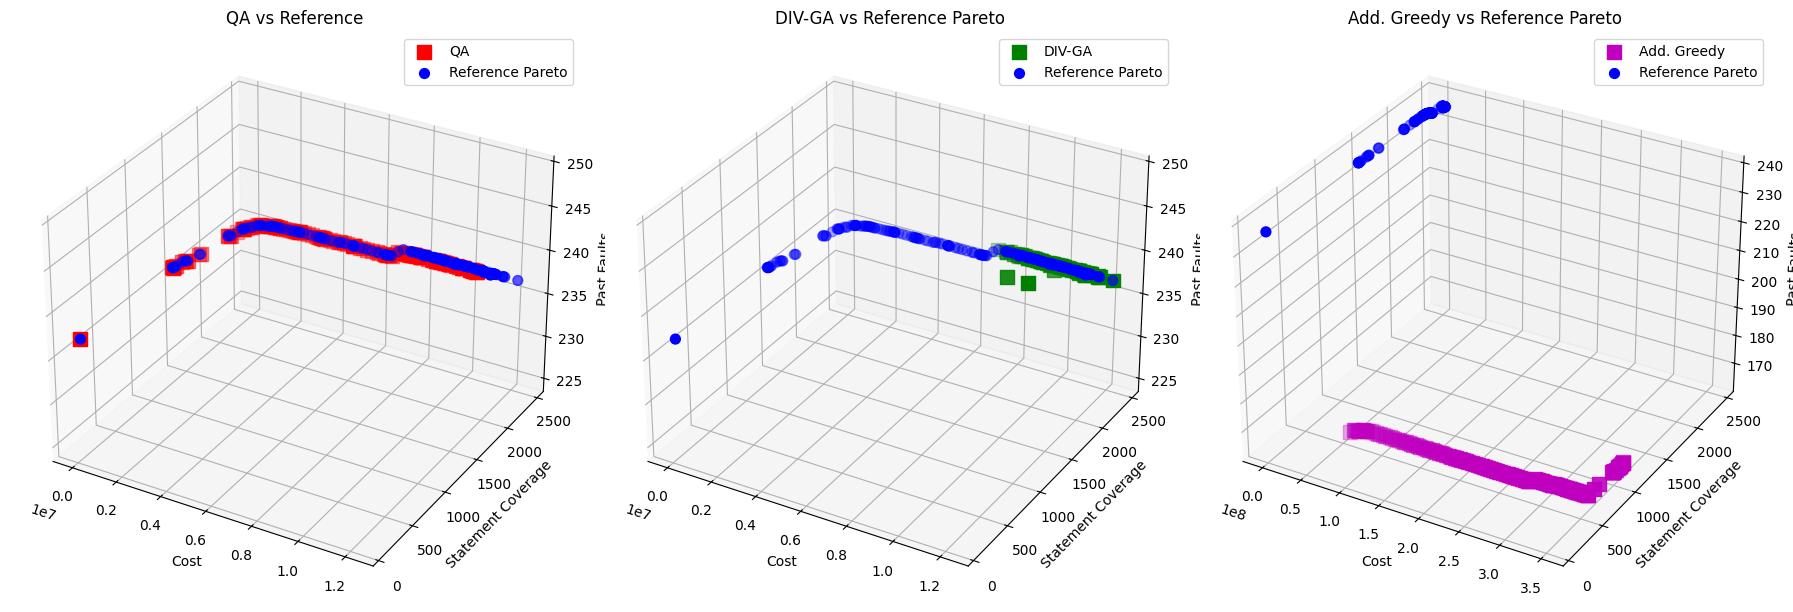

In [180]:
# Unpack the tuples for each list
def unpack_tuples(data):
    return zip(*data)

#qtcs_pareto_vectors,divga_pareto_vectors,greedy_pareto_vectors

x1, y1, z1 = unpack_tuples(qtcs_pareto_vectors)
x2, y2, z2 = unpack_tuples(divga_pareto_vectors)
x3, y3, z3 = unpack_tuples(greedy_pareto_vectors)
x4, y4, z4 = unpack_tuples(reference_pareto)

# Create 3D scatter plots
fig = plt.figure(figsize=(18,6))

# First plot: list1 vs list4
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(x1, y1, z1, c='r', marker='s', s=100, label='QA')
ax1.scatter(x4, y4, z4, c='b', marker='o', s=50, label='Reference Pareto')
ax1.set_xlabel('Cost')
ax1.set_ylabel('Statement Coverage')
ax1.set_zlabel('Past Faults')
ax1.set_title('QA vs Reference')
ax1.legend()

# Second plot: list2 vs list4
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(x2, y2, z2, c='g', marker='s', s=100, label='DIV-GA')
ax2.scatter(x4, y4, z4, c='b', marker='o', s=50, label='Reference Pareto')
ax2.set_xlabel('Cost')
ax2.set_ylabel('Statement Coverage')
ax2.set_zlabel('Past Faults')
ax2.set_title('DIV-GA vs Reference Pareto')
ax2.legend()

# Third plot: list3 vs list4
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(x3, y3, z3, c='m', marker='s', s=100, label='Add. Greedy')
ax3.scatter(x4, y4, z4, c='b', marker='o', s=50, label='Reference Pareto')
ax3.set_xlabel('Cost')
ax3.set_ylabel('Statement Coverage')
ax3.set_zlabel('Past Faults')
ax3.set_title('Add. Greedy vs Reference Pareto')
ax3.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [182]:
qtcs_nondom_flex = [194,207,216,220,212,200,211,203,213,204]
div_ga_nondom_flex = [134,140,139,140,140,140,133,140,136,139]
add_greedy_nondom_flex = [1,0,0,0,1,1,1,0,1,0]

qtcs_nondom_grep = [217,233,230,240,235,205,227,211,259,242]
div_ga_nondom_grep = [69,49,70,70,67,70,57,68,65,54]
add_greedy_nondom_grep = [56,60,56,27,60,93,54,24,26,81]

qtcs_nondom_gzip = [77,70,74,32,81,41,64,41,42,56]
div_ga_nondom_gzip = [88,95,97,96,94,101,96,83,87,51]
add_greedy_nondom_gzip = [0,0,0,0,1,0,0,0,0,0]

qtcs_nondom_sed = [109,123,133,125,123,115,130,104,125,108]
div_ga_nondom_sed = [70,62,97,78,87,94,97,91,100,102]
add_greedy_nondom_sed = [0,0,0,0,0,0,0,0,0,0]

"""qtcs_mean = statistics.mean(qtcs)
qtcs_stdev = statistics.stdev(qtcs)
div_ga_mean = statistics.mean(div_ga)
div_ga_stdev = statistics.stdev(div_ga)
add_greedy_mean = statistics.mean(add_greedy)
add_greedy_stdev = statistics.stdev(add_greedy)

print(qtcs_mean)
print(qtcs_stdev)
print(div_ga_mean)
print(div_ga_stdev)
print(add_greedy_mean)
print(add_greedy_stdev)"""

'qtcs_mean = statistics.mean(qtcs)\nqtcs_stdev = statistics.stdev(qtcs)\ndiv_ga_mean = statistics.mean(div_ga)\ndiv_ga_stdev = statistics.stdev(div_ga)\nadd_greedy_mean = statistics.mean(add_greedy)\nadd_greedy_stdev = statistics.stdev(add_greedy)\n\nprint(qtcs_mean)\nprint(qtcs_stdev)\nprint(div_ga_mean)\nprint(div_ga_stdev)\nprint(add_greedy_mean)\nprint(add_greedy_stdev)'

In [184]:
print("ciao")

ciao


In [12]:
#old (original) sampling cell
sampler = LeapHybridSampler(token="API_KEY")

responses_dictionary = {"flex":[],"grep":[],"gzip":[],"sed":[]}
run_times_dictionary = {"flex":[],"grep":[],"gzip":[],"sed":[]}
I_CE_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}

I_CE_points = {"flex":[],"grep":[],"gzip":[],"sed":[]}

#I want to run the sampler 30 times to obtain different results for each sir program
for sir_program in sir_programs:
    response = None
    for _ in range(tot_run):
        #for each iteration get the result
        response = sampler.sample_qubo(qubos_dictionary[sir_program].to_numpy_matrix())
        sample_dictionary = {i: response.samples()[0][i] for i in range(len(response.samples()[0]))}
        responses_dictionary[sir_program].append(sample_dictionary)
        run_times_dictionary[sir_program].append(response.info["run_time"])
        
        
        
    #compute I_CE and save the I_CE points to make the final plots
    I_H = 0
    for solution in range(len(responses_dictionary[sir_program])):
        if solution == 0:
            solution_cost = get_solution_cost(solution,responses_dictionary[sir_program],sir_program)
            I_H += solution_cost
            total_solution_faults = 0
            for test_case, var_x in responses_dictionary[sir_program][solution].items():
                if var_x:
                    total_solution_faults += faults_dictionary[sir_program][test_case]
            I_CE_points[sir_program].append((solution_cost,total_solution_faults))
        else:
            solution_cost = get_solution_cost(solution,responses_dictionary[sir_program],sir_program)
            I_H += (get_solution_cost(solution+1,responses_dictionary[sir_program],sir_program)-solution_cost)*(1-get_total_fault_coverage(solution,responses_dictionary[sir_program],sir_program))
            total_solution_faults = 0
            for test_case, var_x in responses_dictionary[sir_program][solution].items():
                if var_x:
                    total_solution_faults += faults_dictionary[sir_program][test_case]
            I_CE_points[sir_program].append((solution_cost,total_solution_faults))
    if I_H<0: I_H *= -1
    I_CE_dictionary[sir_program] = I_H/get_solution_cost(len(responses_dictionary[sir_program])-1,responses_dictionary[sir_program],sir_program)
    #print the time information of the last run of the sir program
    run_time = response.info["run_time"]/1000000
    
    #Show the results
    print("INFORMATION FOR " + sir_program + ":")
    print("I_CE: " + str(I_CE_dictionary[sir_program]))
    print("TOTAL TIME: ", run_time, "seconds\n")

C:\Users\anton\AppData\Local\Temp\ipykernel_15192\1670916097.py:23: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  response = sampler.sample_qubo(qubos_dictionary[sir_program].to_numpy_matrix())


INFORMATION FOR flex:
I_CE: 1.2233361073582396
TOTAL TIME:  2.991724 seconds

INFORMATION FOR grep:
I_CE: 0.5197864952963451
TOTAL TIME:  2.992273 seconds

INFORMATION FOR gzip:
I_CE: 0.5195217755961453
TOTAL TIME:  2.986435 seconds

INFORMATION FOR sed:
I_CE: 0.5259592562813199
TOTAL TIME:  2.988043 seconds


In [3]:
def bootstrap_confidence_interval(data, num_samples, confidence_alpha=0.95):
    """This function determines the statistical range within we would expect the mean value of execution times to fall; it relies on the bootstrapping strategy, which allows the calculation of the confidence interval by repeated sampling (with replacement) from the existing data to obtain an estimate of the confidence interval."""
    sample_means = []
    for _ in range(num_samples):
        bootstrap_sample = [random.choice(data) for _ in range(len(data))]
        sample_mean = np.mean(bootstrap_sample)
        sample_means.append(sample_mean)
    
    lower_percentile = (1 - confidence_alpha) / 2 * 100
    upper_percentile = (confidence_alpha + (1 - confidence_alpha) / 2) * 100
    lower_bound = np.percentile(sample_means, lower_percentile)
    upper_bound = np.percentile(sample_means, upper_percentile)
    
    return lower_bound, upper_bound

In [23]:
confidence_interval_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}
num_bootstrap_samples = 1000  #number of bootstrap samples
confidence_alpha = 0.95  #confidence level

#apply the bootstrapping for each sir program
for sir_program in sir_programs:
    run_times = run_times_dictionary[sir_program]
    lower_bound, upper_bound = bootstrap_confidence_interval(run_times, num_bootstrap_samples, confidence_alpha)
    confidence_interval_dictionary[sir_program] = (lower_bound, upper_bound)

#show for each sir program the run time confidence interval
for sir_program in confidence_interval_dictionary.keys():
    print(f"Intervallo di confidenza per {sir_program}: ({confidence_interval_dictionary[sir_program][0]/1000000:.4f}, {confidence_interval_dictionary[sir_program][1]/1000000:.4f})")

Intervallo di confidenza per flex: (2.9937, 2.9966)
Intervallo di confidenza per grep: (2.9939, 2.9965)
Intervallo di confidenza per gzip: (2.9908, 2.9937)
Intervallo di confidenza per sed: (2.9890, 2.9924)


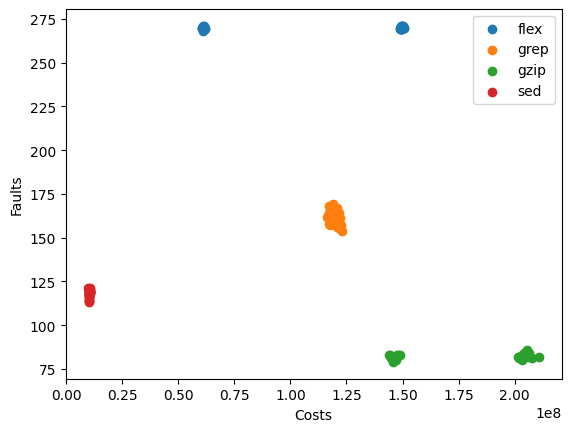

In [24]:
#draw the plot for all the solutions together
for sir_program in sir_programs:
    x,y = zip(*I_CE_points[sir_program])
    plt.scatter(x, y, label=sir_program)
    plt.xlabel('Costs')
    plt.ylabel('Faults')
    plt.legend()

PLOT JUST FOR: flex


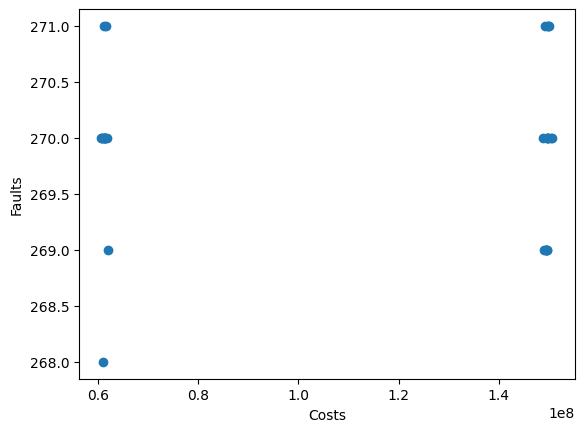

PLOT JUST FOR: grep


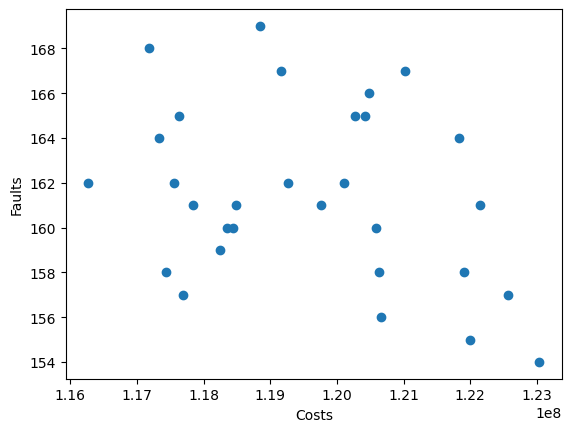

PLOT JUST FOR: gzip


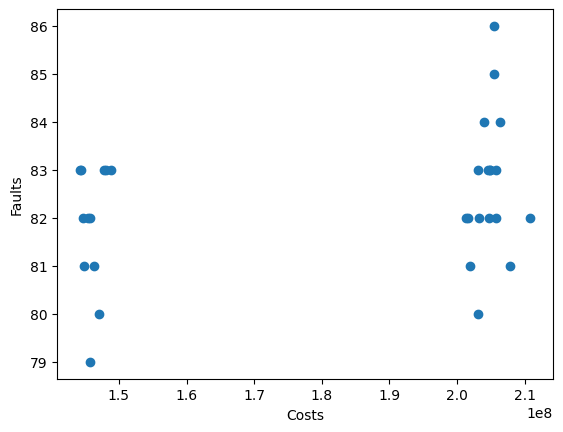

PLOT JUST FOR: sed


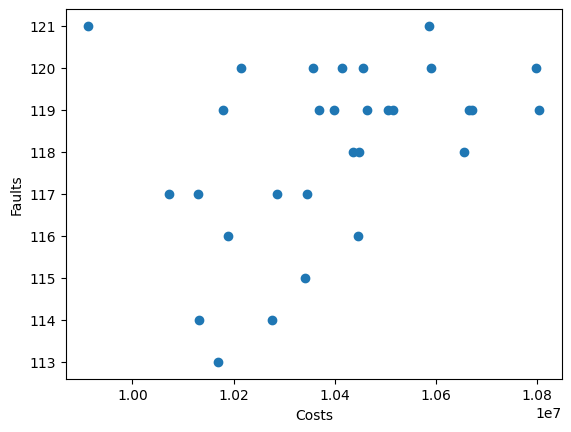

In [25]:
#draw the plot for all the solutions all together
for sir_program in sir_programs:
    x,y = zip(*I_CE_points[sir_program])
    print("PLOT JUST FOR: " + sir_program)
    plt.scatter(x, y)
    plt.xlabel('Costs')
    plt.ylabel('Faults')
    plt.show()

## Simulated Annealing

The quantum annealing process is not effective as the classical MOGA and greedy solution. The question now is to understand if the problem depends on the nature of the annealing process or on the quantum nature of the proposed solution. To do so, is now implemented the classical simulated annealing.

The SA algorithm is based on the annealing process used in metallurgy, where a metal is heated to a high temperature quickly and then gradually cooled. At high temperatures, the atoms move fast, and when the temperature is reduced, their kinetic energy decreases as well. At the end of the annealing process, the atoms fall into a more ordered state, and the material is more ductile and easier to work with.

Similarly, in SA, a search process starts with a high-energy state (an initial solution) and gradually lowers the temperature (a control parameter) until it reaches a state of minimum energy (the optimal solution).

The simulated annealing process starts with an initial solution and then iteratively improves the current solution by randomly perturbing it and accepting the perturbation with a certain probability. The probability of accepting a worse solution is initially high and gradually decreases as the number of iterations increases.

In [21]:
def compute_solution_energy(solution,sir_program):
    """This function computes the energy of a solution"""
    solution_cost = 0
    for test_case, test_case_cost in enumerate(test_cases_costs[sir_program]):
        solution_cost += (test_case_cost * solution[test_case])
    solution_cost *= alpha
    
    detected_faults = 0
    for test_case, fault_value in enumerate(faults_dictionary[sir_program]):
        if sir_program == "grep" and test_case == 806:
            break
        detected_faults += (fault_value * solution[test_case])
    detected_faults *= (1 - alpha)
    
    statement_coverage = 0
    for k in coverage[sir_program].keys():
        test_cases = coverage[sir_program][k]
        for i in test_cases:
            for j in test_cases:
                if i < j:
                    statement_coverage += ((solution[i] * (-1 * penalties_dictionary[sir_program]))
                    + (2 * penalties_dictionary[sir_program] * solution[i] * solution[j]))
                    
    return solution_cost - detected_faults + statement_coverage

In [22]:
def generate_new_solution(sir_program,solution):
    """This function generate a new candidate solution near to the actual solution by flipping 1/3 of the bits of the solution string representing a test suite"""
    for _ in range(sir_programs_tests_number[sir_program]//3):
        random_test_case = random.randint(0,sir_programs_tests_number[sir_program]-1)
        if solution[random_test_case] == 1:
            solution[random_test_case] = 0
        else:
            solution[random_test_case] = 1

    return solution

In [23]:
def is_soluction_accepted(temperature,delta_energy):
    """This function determines whether a new solution is accepted or rejected"""
    if delta_energy < 0:
        return True
    else:
        r = random.random()
        if r < math.exp((-delta_energy)/temperature):
            return True
        else:
            return False

In [24]:
def simulated_annealing(sir_program,annealing_alpha):
    """This function implements the simulated annealing algorithm for the test case selection problem"""
    iteration = 1
    temperature = 80000
    solution = {key: 1 for key in range(sir_programs_tests_number[sir_program])}
    energy = compute_solution_energy(solution,sir_program)
    
    while temperature > 10:
        print("iterazione numero: " + str(iteration) + "\n")
        new_solution = generate_new_solution(sir_program,solution)
        new_energy = compute_solution_energy(new_solution,sir_program)
        energy_delta = energy - new_energy
        if is_soluction_accepted(temperature,energy_delta):
            solution = new_solution
            energy = new_energy
        temperature *= (annealing_alpha ** iteration)
        iteration += 1
    
    return solution

In [ ]:
#now the simulated annealing must be run for all the different experimentation's, and the hypervolume metric must be registered to make the correct comparisons

solutions_dictionary = {"flex":[],"grep":[],"gzip":[],"sed":[]}
I_CE_simulated_annealing_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}

for sir_program in sir_programs:
    it = 1
    for _ in range(tot_run):
        print("inizio run numero " + str(it) + "/30 per il programma: " + sir_program + "\n")
        solutions_dictionary[sir_program].append(simulated_annealing(sir_program,0.87))
        print("fine run numero " + str(it) + "/30 per il programma: " + sir_program + "\n")
        it += 1
        
    I_H = 0
    
    for solution in range(len(solutions_dictionary[sir_program])):
        if solution == 0:
            solution_cost = get_solution_cost(solution,solutions_dictionary[sir_program],sir_program)
            I_H += solution_cost
            total_solution_faults = 0
            for test_case, var_x in solutions_dictionary[sir_program][solution].items():
                if var_x:
                    total_solution_faults += faults_dictionary[sir_program][test_case]
        else:
            solution_cost = get_solution_cost(solution,solutions_dictionary[sir_program],sir_program)
            I_H += (get_solution_cost(solution+1,solutions_dictionary[sir_program],sir_program)-solution_cost)*(1-get_total_fault_coverage(solution,solutions_dictionary[sir_program],sir_program))
            total_solution_faults = 0
            for test_case, var_x in solutions_dictionary[sir_program][solution].items():
                if var_x:
                    total_solution_faults += faults_dictionary[sir_program][test_case]
    if I_H<0: I_H *= -1
    I_CE_simulated_annealing_dictionary[sir_program] = I_H/get_solution_cost(len(solutions_dictionary[sir_program])-1,solutions_dictionary[sir_program],sir_program)
    
    #Show the results
    print("INFORMATION FOR " + sir_program + ":")
    print("I_CE: " + str(I_CE_simulated_annealing_dictionary[sir_program]))

In [7]:
def get_failure_rate(sir_program, selected_test_case):
    """This function opens the fault-matrix file of a sir programs
     and makes a list of binary values for each test case of that program to indicate
      whether a test case found or not a bug in at least one of the available versions of the program"""
    # open the fault-matrix file of the desired SIR program

    file_path = f"SIR_Programs/{sir_program}/fault-matrix.txt"
    
    # open the file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # take the selected_test_case line
    selected_row = lines[selected_test_case]
    
    # compute the percentage of zeros
    num_zeros = selected_row.count('1')
    total_digits = len(selected_row.strip())
    zero_percentage = (num_zeros / total_digits)
    
    return zero_percentage

In [40]:
sampler = LeapHybridSampler(token="DEV-3d4e05af10e81fe4d091232d72f6b81b107cadb4",qpu=True)

run_times_dictionary = {"flex":[],"grep":[],"gzip":[],"sed":[]} 

#I want to run the sampler 30 times to obtain different results for each sir program
for sir_program in sir_programs:
    response = None
    first_sample_dictionary = {}
    final_test_suite_costs = []
    final_failure_rates = []
    final_coverage_levels = []
    i = 0
    for i in range(tot_run):
        #for each iteration get the result
        response = sampler.sample_qubo(qubos_dictionary[sir_program].to_numpy_matrix())
        run_times_dictionary[sir_program].append(response.info['qpu_access_time'])
        
        first_sample_dictionary = {i: response.samples()[0][i] for i in range(len(response.samples()[0]))}
    
        #make a list with only the ids of test cases selected by the final solution
        final_selected_cases = [id for id, value in first_sample_dictionary.items() if value == 1]
        
        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[sir_program][selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)
            
        #compute the total failure rate
        final_failure_rate = 0
        for selected_test_case in final_selected_cases:
            final_failure_rate += get_failure_rate(sir_program,selected_test_case)    
        final_failure_rates.append(final_failure_rate)
        
        #make a set of all the covered lines (no repetitions) by test cases selected by the last solution
        covered_lines = set()
        for selected_test_case in final_selected_cases:
            try:
                for line_number in lines_of_tests_list[sir_program][selected_test_case]:
                    covered_lines.add(line_number)
            except Exception:
                print("")
        coverage_level = len(covered_lines)/total_file_lines[sir_program]
        final_coverage_levels.append(coverage_level)
    
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[sir_program]:
      if access_time != 0:
        qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[sir_program])):
      if run_times_dictionary[sir_program][i] == 0:
          run_times_dictionary[sir_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[sir_program]) 
    
    var_names = ["final_test_suite_costs", "final_failure_rates", "final_coverage_levels", "average_qpu_access_time(ms)", "qpu_lower_bound(ms)", "qpu_upper_bound()"]
    values = [final_test_suite_costs, final_failure_rates, final_coverage_levels, average_qpu_access_time, lower_bound, upper_bound]
    
    with open("SIR_Programs/"+sir_program+"/sum.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)  
        writer.writerow(values)


 TOT RUN PER PROGRAM: 10



C:\Users\anton\AppData\Local\Temp\ipykernel_2796\1400646271.py:16: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  response = sampler.sample_qubo(qubos_dictionary[sir_program].to_numpy_matrix())



PROGRAM: flex, run #0

qpu_access_time: 42753

test_suite_cost: 149948434

final_failure_rate: 121.00000000000051

coverage_level: 0.7512049575395915


PROGRAM: flex, run #1

qpu_access_time: 42739

test_suite_cost: 60473223

final_failure_rate: 122.6000000000005

coverage_level: 0.7505164103741107


PROGRAM: flex, run #2

qpu_access_time: 42744

test_suite_cost: 60960102

final_failure_rate: 121.00000000000048

coverage_level: 0.7289419325223778


PROGRAM: flex, run #3

qpu_access_time: 42749

test_suite_cost: 61324428

final_failure_rate: 122.00000000000051

coverage_level: 0.7477622217121873


PROGRAM: flex, run #4

qpu_access_time: 42750

test_suite_cost: 60829048

final_failure_rate: 121.60000000000053

coverage_level: 0.7463851273812256


PROGRAM: flex, run #5

qpu_access_time: 42737

test_suite_cost: 61881597

final_failure_rate: 121.00000000000051

coverage_level: 0.7544181776451687


PROGRAM: flex, run #6

qpu_access_time: 42749

test_suite_cost: 61361336

final_failure_rate:

In [9]:
for sir_program in sir_programs:
    max_cost = 0
    for test_case in range(0,sir_programs_tests_number[sir_program]):
      max_cost += test_cases_costs[sir_program][test_case]
        
    #compute the total failure rate
    max_failure_rate = 0
    for test_case in range(0,sir_programs_tests_number[sir_program]):
        max_failure_rate += get_failure_rate(sir_program,test_case) 
    
    #make a set of all the covered lines (no repetitions) by test cases selected by the last solution
    covered_lines = set()
    for test_case in range(0,sir_programs_tests_number[sir_program]):
        try:
            for line_number in lines_of_tests_list[sir_program][test_case]:
                covered_lines.add(line_number)
        except Exception:
            print("")
    coverage_level = len(covered_lines)/total_file_lines[sir_program]

    print("ORIGINAL TEST SUITE VALUES FOR PROGRAM: " + sir_program + "\n")
    print("test suite cost: " + str(max_cost) + "\n")
    print("test suite failure rate: " + str(max_failure_rate) + "\n")
    print("test suite coverage level: " + str(coverage_level) + "\n")

print("FINE")

ORIGINAL TEST SUITE VALUES FOR PROGRAM: flex

test suite cost: 210649552

test suite failure rate: 243.00000000000207

test suite coverage level: 0.7796649070461327


ORIGINAL TEST SUITE VALUES FOR PROGRAM: grep

test suite cost: 238894086

test suite failure rate: 741.8000000000022

test suite coverage level: 0.59375




ORIGINAL TEST SUITE VALUES FOR PROGRAM: gzip

test suite cost: 350943086

test suite failure rate: 181.00000000000043

test suite coverage level: 0.5580137659783677

ORIGINAL TEST SUITE VALUES FOR PROGRAM: sed

test suite cost: 20774515

test suite failure rate: 303.1666666666665

test suite coverage level: 0.4584823950291847

FINE


In [4]:
def create_linear_bqm(test_cases_costs,test_cases_rates,alpha):
    """This function is the one that has to encode the QUBO problem that the D-Wave Hybrid Sampler will have to solve. The QUBO problem specifies the optimization to solve and a quadratic binary unconstrained problem"""
    qubo = dimod.AdjVectorBQM(dimod.BINARY)
    
    max_cost = max(test_cases_costs)

    #linear coefficients, that are the diagonal of the matrix encoding the QUBO
    for i in range(len(test_cases_costs)):
        cost = (alpha * ((test_cases_costs[i])/max_cost)) - ((1-alpha)*test_cases_rates[i])
        qubo.set_linear(i, cost)

    return qubo

In [7]:
bootqa_programs = ["gsdtsr"]
bootqa_alphas = {"gsdtsr": 0.98,"paintcontrol": 0.9}
run_times_dictionary = {"gsdtsr": [],"paintcontrol": []}
sampler = LeapHybridSampler(token="DEV-fe0b6a258ec14e7927bb90dfaf7217f6920deff6",qpu=True)

def get_data(data_name):
    data = pd.read_csv("BootQA_Programs/"+data_name+"/"+data_name+".csv", dtype={"time": float, "rate": float})
    #I just consider data with failure rate > 0 (because it means they found at least 1 fault)
    data = data.drop(data[data['rate'] == 0].index)
    #this way every case has 1 as bool failure value
    return data

for bootqa_program in bootqa_programs:
    final_test_suite_costs = []
    final_failure_rates = []
    for _ in range(tot_run):
        data = get_data(bootqa_program)
        test_cases_costs = data["time"].tolist()
        test_cases_rates = data["rate"].tolist()
        linear_bqm = create_linear_bqm(test_cases_costs, test_cases_rates, bootqa_alphas[bootqa_program])
        #for each iteration get the result
        response = sampler.sample_qubo(linear_bqm.to_numpy_matrix())
        run_times_dictionary[bootqa_program].append(response.info['qpu_access_time'])
        
        first_sample_dictionary = {i: response.samples()[0][i] for i in range(len(response.samples()[0]))}
    
        #make a list with only the ids of test cases selected by the final solution
        final_selected_cases = [id for id, value in first_sample_dictionary.items() if value == 1]
        
        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)
            
        #compute the total failure rate
        final_failure_rate = 0
        for selected_test_case in final_selected_cases:
            final_failure_rate += test_cases_rates[selected_test_case]
        final_failure_rates.append(final_failure_rate)
    
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
      if access_time != 0:
        qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
      if run_times_dictionary[bootqa_program][i] == 0:
          run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program]) 
    
    var_names = ["final_test_suite_costs", "final_failure_rates",
                 "average_qpu_access_time(ms)", "qpu_lower_bound(ms)", "qpu_upper_bound()"]
    values = [final_test_suite_costs, final_failure_rates, average_qpu_access_time, lower_bound, upper_bound]
    
    with open("BootQA_Programs/"+bootqa_program+"/sum.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)

C:\Users\anton\AppData\Local\Temp\ipykernel_17632\781093828.py:22: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  response = sampler.sample_qubo(linear_bqm.to_numpy_matrix())
